In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Data Loading

In [2]:
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

In [3]:
df_train.shape

(41157, 6)

In [4]:
df_test.shape

(3798, 6)

In [5]:
df = pd.concat([df_train, df_test], ignore_index=True)

# Display the first few rows of the merged dataframe
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
df.shape

(44955, 6)

### EDA

/tmp/ipython-input-3848970660.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=label_counts.index, x=label_counts.values, palette='viridis')


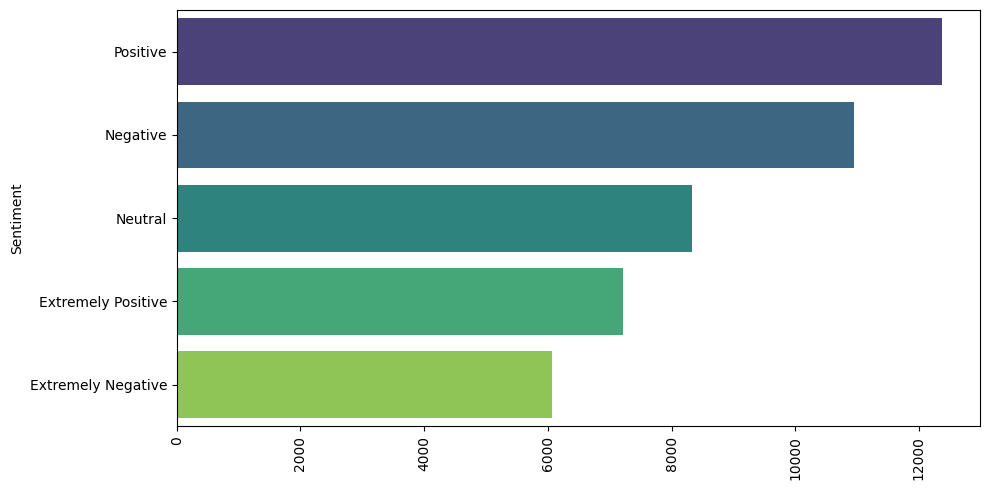

In [7]:
label_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(y=label_counts.index, x=label_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2582251714.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=label_counts.index, x=label_counts.values, palette='viridis')


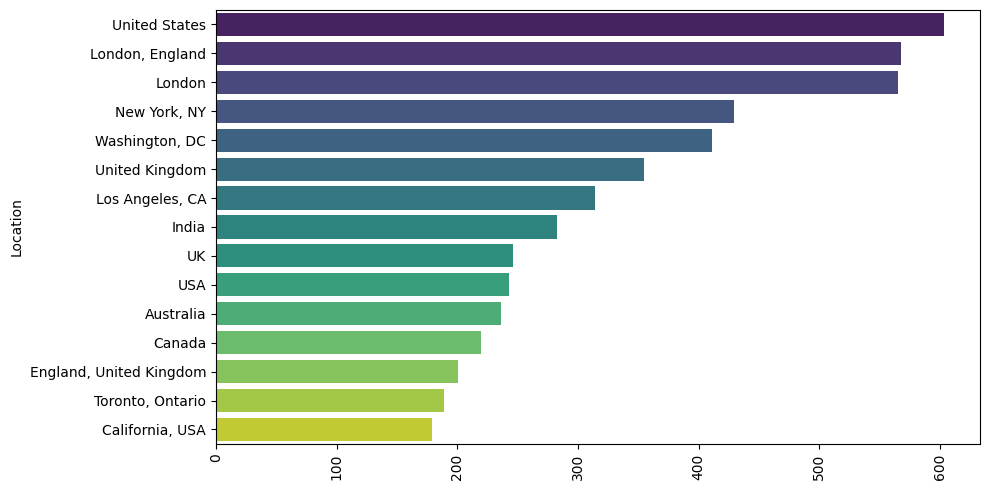

In [8]:
# Shows top 15 locations
label_counts = df['Location'].value_counts().iloc[0:15]

plt.figure(figsize=(10, 5))
sns.barplot(y=label_counts.index, x=label_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Text Preprocessing

In [9]:
import re
import string

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_.-]+', '', text) # menghapus mention (termasuk underscore, hyphen, dan dot)
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

In [10]:
from nltk.corpus import stopwords

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_text = [word for word in words if word not in stop_words]
    return ' '.join(filtered_text)

In [11]:
def casefoldingText(text):
    text = text.lower()
    return text

In [12]:
from nltk.tokenize import sent_tokenize

def tokenizingText(text):
    text = word_tokenize(text)
    return text

In [13]:
def lemmitizingText(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

In [14]:
df['cleaningText'] = df['OriginalTweet'].apply(cleaningText)
df['text_casefoldingText'] = df['cleaningText'].apply(casefoldingText)
df['text_processed'] = df['text_casefoldingText'].apply(remove_stopwords)
df['text_tokenizing'] = df['text_processed'].apply(tokenizingText)
df['text_lemmitizing'] = df['text_tokenizing'].apply(lemmitizingText)

In [15]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cleaningText,text_casefoldingText,text_processed,text_tokenizing,text_lemmitizing
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and,and and,,[],[]
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,advice talk to your neighbours family to excha...,advice talk neighbours family exchange phone n...,"[advice, talk, neighbours, family, exchange, p...","[advice, talk, neighbour, family, exchange, ph..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...,coronavirus australia woolworths to give elder...,coronavirus australia woolworths give elderly ...,"[coronavirus, australia, woolworths, give, eld...","[coronavirus, australia, woolworth, give, elde..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,my food stock is not the only one which is emp...,food stock one empty please dont panic enough ...,"[food, stock, one, empty, please, dont, panic,...","[food, stock, one, empty, please, dont, panic,..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the outb...,me ready to go at supermarket during the outb...,ready go supermarket outbreak im paranoid food...,"[ready, go, supermarket, outbreak, im, paranoi...","[ready, go, supermarket, outbreak, im, paranoi..."


### Feature Extraction

In [16]:
df_cleaned = df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt', 'cleaningText', 'text_casefoldingText', 'text_processed', 'text_tokenizing'])
df_cleaned.head()

,OriginalTweet,Sentiment,text_lemmitizing
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[]
1,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, neighbour, family, exchange, ph..."
2,Coronavirus Australia: Woolworths to give elde...,Positive,"[coronavirus, australia, woolworth, give, elde..."
3,My food stock is not the only one which is emp...,Positive,"[food, stock, one, empty, please, dont, panic,..."
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[ready, go, supermarket, outbreak, im, paranoi..."


In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_cleaned['Sentiment_Encoded'] = label_encoder.fit_transform(df_cleaned['Sentiment'])
df_cleaned.head()

,OriginalTweet,Sentiment,text_lemmitizing,Sentiment_Encoded
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[],3
1,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, neighbour, family, exchange, ph...",4
2,Coronavirus Australia: Woolworths to give elde...,Positive,"[coronavirus, australia, woolworth, give, elde...",4
3,My food stock is not the only one which is emp...,Positive,"[food, stock, one, empty, please, dont, panic,...",4
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[ready, go, supermarket, outbreak, im, paranoi...",0


- 0: Extremely Negative
- 1: Extremely Positive
- 2: Negative
- 3: Neutral
- 4: Positive

In [18]:
df_cleaned = df_cleaned.drop(columns=['Sentiment'])
df_cleaned.head()

,OriginalTweet,text_lemmitizing,Sentiment_Encoded
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,[],3
1,advice Talk to your neighbours family to excha...,"[advice, talk, neighbour, family, exchange, ph...",4
2,Coronavirus Australia: Woolworths to give elde...,"[coronavirus, australia, woolworth, give, elde...",4
3,My food stock is not the only one which is emp...,"[food, stock, one, empty, please, dont, panic,...",4
4,"Me, ready to go at supermarket during the #COV...","[ready, go, supermarket, outbreak, im, paranoi...",0


In [19]:
from tkinter.constants import X
from sklearn.feature_extraction.text import TfidfVectorizer

X = df_cleaned['text_lemmitizing'].apply(lambda x: ' '.join(x))

tfidf=TfidfVectorizer(max_features=10000)
X_transformed=tfidf.fit_transform(X)
X_transformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 636504 stored elements and shape (44955, 10000)>

### Modelling & Evaluation

#### Logistic Regression TF-IDF

In [20]:
# Bagi data menjadi data latih dan data uji (85% digunakan untuk training, 15% digunakan untuk testing)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, df_cleaned.Sentiment_Encoded, test_size=0.15, random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38211, 10000), (6744, 10000), (38211,), (6744,))

In [22]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=100)

logistic_regression.fit(X_train, y_train)

y_pred_train_lr = logistic_regression.predict(X_train)
y_pred_test_lr = logistic_regression.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train_lr))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73      5183
           1       0.83      0.70      0.76      6158
           2       0.70      0.73      0.72      9321
           3       0.78      0.82      0.80      7038
           4       0.70      0.79      0.74     10511

    accuracy                           0.75     38211
   macro avg       0.77      0.74      0.75     38211
weighted avg       0.75      0.75      0.75     38211



In [24]:
print(classification_report(y_test, y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.66      0.48      0.55       890
           1       0.67      0.51      0.58      1065
           2       0.53      0.54      0.54      1637
           3       0.64      0.72      0.68      1294
           4       0.53      0.62      0.57      1858

    accuracy                           0.58      6744
   macro avg       0.61      0.57      0.58      6744
weighted avg       0.59      0.58      0.58      6744



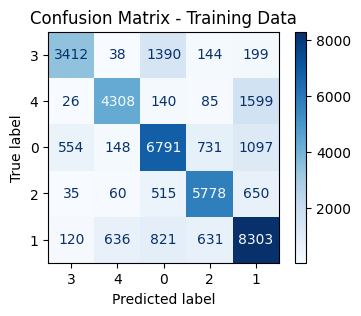

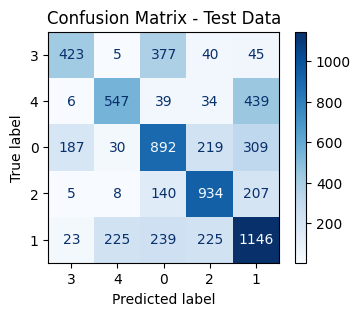

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_pred_train_lr)
cmd_train = ConfusionMatrixDisplay(conf_matrix_train, display_labels=df_cleaned['Sentiment_Encoded'].unique())
fig, ax = plt.subplots(figsize=(4, 3))
cmd_train.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix - Training Data")
plt.show()

# Confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, y_pred_test_lr)
cmd_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=df_cleaned['Sentiment_Encoded'].unique())
fig, ax = plt.subplots(figsize=(4, 3))
cmd_test.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix - Test Data")
plt.show()

#### GRU

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)

tokenizer.fit_on_texts(df_cleaned['text_lemmitizing'])

sequences = tokenizer.texts_to_sequences(df_cleaned['text_lemmitizing'])

maxlen = 100
X_padded = pad_sequences(sequences, maxlen=maxlen)

# Prepare the labels
y = df_cleaned['Sentiment_Encoded']

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras import layers

wordIndex = len(tokenizer.word_index) + 1

model = Sequential([
    layers.Embedding(wordIndex, 128, input_length=maxlen),
    layers.GRU(64, return_sequences=True),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.15, random_state=42)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
]

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Epoch 1/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 112s 181ms/step - accuracy: 0.2948 - loss: 1.5326 - val_accuracy: 0.3977 - val_loss: 1.2786 - learning_rate: 0.0010
Epoch 2/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 139s 176ms/step - accuracy: 0.5498 - loss: 1.1437 - val_accuracy: 0.5989 - val_loss: 1.0632 - learning_rate: 0.0010
Epoch 3/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 140s 173ms/step - accuracy: 0.6421 - loss: 0.9710 - val_accuracy: 0.6157 - val_loss: 0.9957 - learning_rate: 0.0010
Epoch 4/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 139s 167ms/step - accuracy: 0.6936 - loss: 0.8560 - val_accuracy: 0.6154 - val_loss: 1.0020 - learning_rate: 0.0010
Epoch 5/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 144s 170ms/step - accuracy: 0.7267 - loss: 0.7833 - val_accuracy: 0.6223 - val_loss: 0.9841 - learning_rate: 0.0010
Epoch 6/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 142s 170ms/step - accuracy: 0.7526 - loss: 0.7179 - val_accuracy: 0.6094 - val_loss: 1.0009 - learning_rate: 0.0010
Epoch 7/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Akurasi pada test set: {test_accuracy * 100:.2f}%")
print(f"Loss pada test set: {test_loss:.4f}")

211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6011 - loss: 1.1778
Akurasi pada test set: 60.07%
Loss pada test set: 1.1547


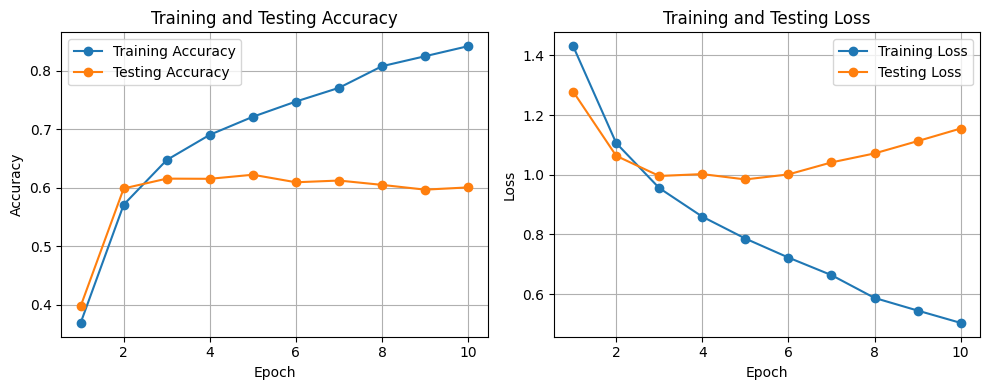

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)


plt.figure(figsize=(10,4))

# Plot Akurasi
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Testing Accuracy', marker='o')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Testing Loss', marker='o')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()